In [1]:
import pandas as pd
import numpy as np
import regex as re

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import pickle

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from time import sleep
from random import randint
from pandas import json_normalize

In [2]:
# Importing csv

In [3]:
top_songs = pd.read_csv('top_songs.csv')

In [4]:
top_songs

,song,artist
0,Lovin On Me,Jack Harlow
1,Lil Boo Thang,Paul Russell
2,I Remember Everything (feat. Kacey Musgraves),Zach Bryan
3,White Horse,Chris Stapleton
4,Need A Favor,Jelly Roll
...,...,...
145,Smells Like Teen Spirit,Nirvana
146,Like a Rolling Stone,Bob Dylan
147,A Change Is Gonna Come,Sam Cooke
148,Fight the Power,Public Enemy


In [5]:
playlist = pd.read_csv('df_playlist.csv')
playlist

,track.name,name,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,2K,Nosaj Thing,33xMbeHzmWd6Od0BmLZEUs,0.310,0.445,7.0,-13.355,0.0,0.0863,0.09400,...,0.1130,0.122,95.360,audio_features,33xMbeHzmWd6Od0BmLZEUs,spotify:track:33xMbeHzmWd6Od0BmLZEUs,https://api.spotify.com/v1/tracks/33xMbeHzmWd6...,https://api.spotify.com/v1/audio-analysis/33xM...,152560.0,3.0
1,4 Billion Souls,The Doors,3UnyplmZaq547hwsfOR5yy,0.419,0.565,5.0,-11.565,1.0,0.0347,0.13700,...,0.1280,0.648,151.277,audio_features,3UnyplmZaq547hwsfOR5yy,spotify:track:3UnyplmZaq547hwsfOR5yy,https://api.spotify.com/v1/tracks/3UnyplmZaq54...,https://api.spotify.com/v1/audio-analysis/3Uny...,197707.0,4.0
2,4 Minute Warning,Radiohead,1w8QCSDH4QobcQeT4uMKLm,0.354,0.302,9.0,-13.078,1.0,0.0326,0.59000,...,0.1110,0.223,123.753,audio_features,1w8QCSDH4QobcQeT4uMKLm,spotify:track:1w8QCSDH4QobcQeT4uMKLm,https://api.spotify.com/v1/tracks/1w8QCSDH4Qob...,https://api.spotify.com/v1/audio-analysis/1w8Q...,244285.0,4.0
3,7 Element,Vitas,7J9mBHG4J2eIfDAv5BehKA,0.727,0.785,5.0,-6.707,0.0,0.0603,0.32500,...,0.3100,0.960,129.649,audio_features,7J9mBHG4J2eIfDAv5BehKA,spotify:track:7J9mBHG4J2eIfDAv5BehKA,https://api.spotify.com/v1/tracks/7J9mBHG4J2eI...,https://api.spotify.com/v1/audio-analysis/7J9m...,249940.0,4.0
4,#9 Dream,R.E.M.,1VZedwJj1gyi88WFRhfThb,0.571,0.724,0.0,-5.967,1.0,0.0260,0.02310,...,0.0919,0.385,116.755,audio_features,1VZedwJj1gyi88WFRhfThb,spotify:track:1VZedwJj1gyi88WFRhfThb,https://api.spotify.com/v1/tracks/1VZedwJj1gyi...,https://api.spotify.com/v1/audio-analysis/1VZe...,278320.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34378,Fool's Overture,Supertramp,5pSSEkT0963muzzIjsVkrs,0.406,0.306,3.0,-10.482,1.0,0.0372,0.31300,...,0.0727,0.073,135.272,audio_features,5pSSEkT0963muzzIjsVkrs,spotify:track:5pSSEkT0963muzzIjsVkrs,https://api.spotify.com/v1/tracks/5pSSEkT0963m...,https://api.spotify.com/v1/audio-analysis/5pSS...,652560.0,4.0
34379,Heart of the Sunrise - 2003 Remaster,Yes,7gC6Rbllqf1yXNC02e5jz2,0.362,0.507,1.0,-11.229,1.0,0.0394,0.01740,...,0.1130,0.456,146.641,audio_features,7gC6Rbllqf1yXNC02e5jz2,spotify:track:7gC6Rbllqf1yXNC02e5jz2,https://api.spotify.com/v1/tracks/7gC6Rbllqf1y...,https://api.spotify.com/v1/audio-analysis/7gC6...,634440.0,3.0
34380,Venus And Mars / Rock Show / Jet - Live / Rema...,Paul McCartney,6Ff77WXC58MkhLE5A1qgY1,0.331,0.733,2.0,-8.671,1.0,0.0468,0.08870,...,0.9470,0.380,128.512,audio_features,6Ff77WXC58MkhLE5A1qgY1,spotify:track:6Ff77WXC58MkhLE5A1qgY1,https://api.spotify.com/v1/tracks/6Ff77WXC58Mk...,https://api.spotify.com/v1/audio-analysis/6Ff7...,620747.0,4.0
34381,Venus And Mars / Rock Show / Jet - Live / Rema...,Wings,6Ff77WXC58MkhLE5A1qgY1,0.331,0.733,2.0,-8.671,1.0,0.0468,0.08870,...,0.9470,0.380,128.512,audio_features,6Ff77WXC58MkhLE5A1qgY1,spotify:track:6Ff77WXC58MkhLE5A1qgY1,https://api.spotify.com/v1/tracks/6Ff77WXC58Mk...,https://api.spotify.com/v1/audio-analysis/6Ff7...,620747.0,4.0


In [6]:
X_playlist = playlist.select_dtypes(include='number')

In [7]:
# KMeans 

In [8]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(X_playlist)
X_prep=transformer.transform(X_playlist)
# Now, all features will have the same weight.
pd.DataFrame(X_prep,columns=X_playlist.columns).head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,-1.673456,-0.978137,0.491240,-1.392378,-1.275564,0.175305,-0.470935,-0.346554,-0.476879,-1.414751,-0.945884,-0.495177,-2.722603
1,-1.002674,-0.416118,-0.064116,-0.940978,0.783967,-0.486384,-0.319312,0.538322,-0.379713,0.709682,1.124034,-0.284319,0.174681
2,-1.402682,-1.647875,1.046597,-1.322525,0.783967,-0.513314,1.278019,-0.336364,-0.489834,-1.006828,0.105159,-0.066778,0.174681
3,0.892748,0.614249,-0.064116,0.284105,-1.275564,-0.158104,0.343598,-0.155247,0.799226,1.969802,0.323415,-0.040367,0.174681
4,-0.067271,0.328557,-1.452506,0.470717,0.783967,-0.597948,-0.720937,-0.559194,-0.613558,-0.352535,-0.153891,0.092181,0.174681


In [9]:
# Chosing K

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

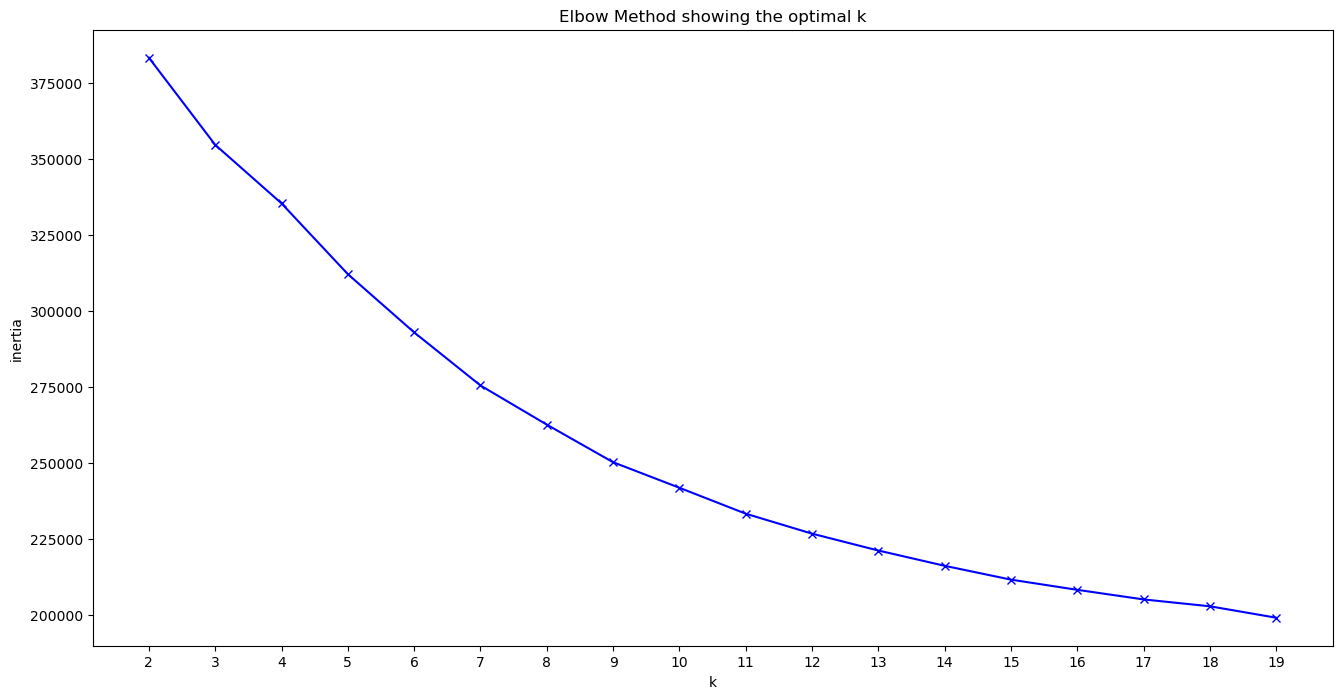

In [10]:
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

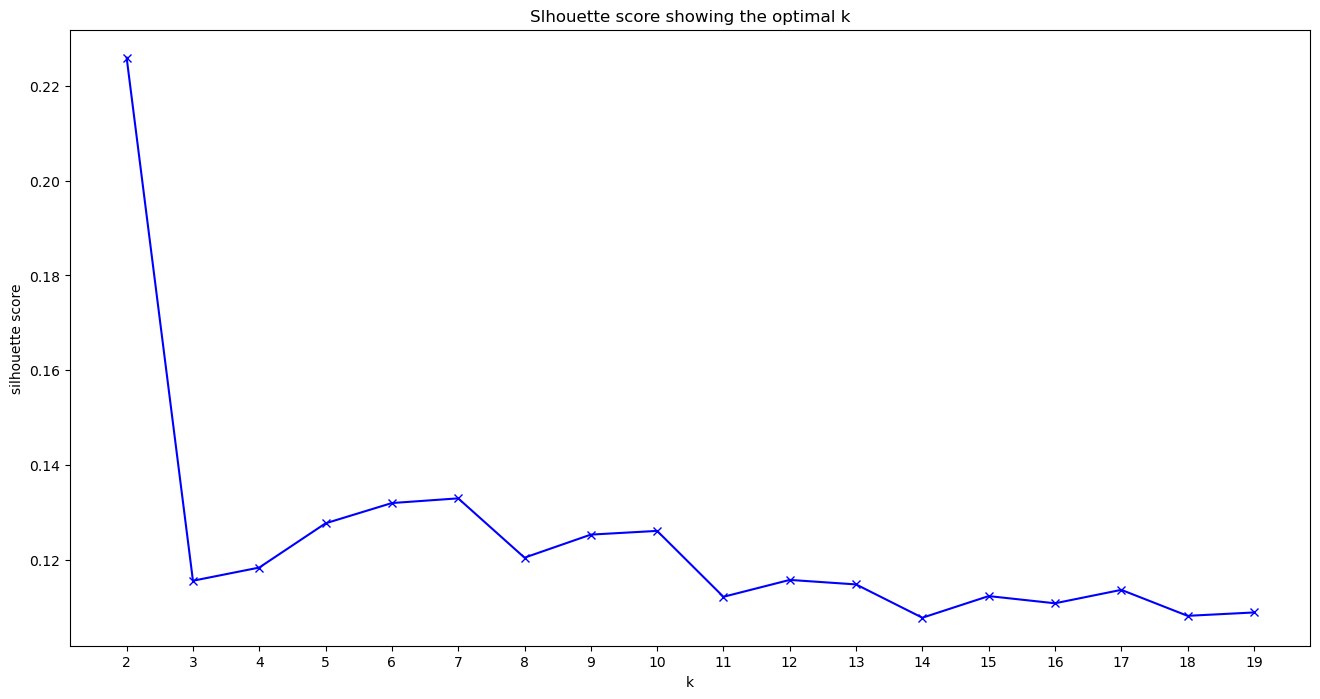

In [11]:
from sklearn.metrics import silhouette_score
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

In [12]:
kmeans = KMeans(n_clusters=17, random_state=1234)
kmeans.fit(X_prep)

KMeans(n_clusters=17, random_state=1234)

In [13]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(X_prep)

# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0     1701
1     2769
2     2615
3     1310
4     2325
5       98
6      686
7     2606
8     3186
9     3510
10     189
11    3829
12    1597
13    1117
14    1541
15    2142
16    3162
dtype: int64

In [14]:
# Saving my model

In [15]:
pickle.dump(kmeans, open('kmeans.pkl', 'wb'))

In [16]:
pickle.dump(transformer, open('X_prep.pkl', 'wb'))

In [17]:
# obtaining song's cluster number
playlist['cluster']= clusters
playlist

,track.name,name,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,cluster
0,2K,Nosaj Thing,33xMbeHzmWd6Od0BmLZEUs,0.310,0.445,7.0,-13.355,0.0,0.0863,0.09400,...,0.122,95.360,audio_features,33xMbeHzmWd6Od0BmLZEUs,spotify:track:33xMbeHzmWd6Od0BmLZEUs,https://api.spotify.com/v1/tracks/33xMbeHzmWd6...,https://api.spotify.com/v1/audio-analysis/33xM...,152560.0,3.0,3
1,4 Billion Souls,The Doors,3UnyplmZaq547hwsfOR5yy,0.419,0.565,5.0,-11.565,1.0,0.0347,0.13700,...,0.648,151.277,audio_features,3UnyplmZaq547hwsfOR5yy,spotify:track:3UnyplmZaq547hwsfOR5yy,https://api.spotify.com/v1/tracks/3UnyplmZaq54...,https://api.spotify.com/v1/audio-analysis/3Uny...,197707.0,4.0,1
2,4 Minute Warning,Radiohead,1w8QCSDH4QobcQeT4uMKLm,0.354,0.302,9.0,-13.078,1.0,0.0326,0.59000,...,0.223,123.753,audio_features,1w8QCSDH4QobcQeT4uMKLm,spotify:track:1w8QCSDH4QobcQeT4uMKLm,https://api.spotify.com/v1/tracks/1w8QCSDH4Qob...,https://api.spotify.com/v1/audio-analysis/1w8Q...,244285.0,4.0,16
3,7 Element,Vitas,7J9mBHG4J2eIfDAv5BehKA,0.727,0.785,5.0,-6.707,0.0,0.0603,0.32500,...,0.960,129.649,audio_features,7J9mBHG4J2eIfDAv5BehKA,spotify:track:7J9mBHG4J2eIfDAv5BehKA,https://api.spotify.com/v1/tracks/7J9mBHG4J2eI...,https://api.spotify.com/v1/audio-analysis/7J9m...,249940.0,4.0,2
4,#9 Dream,R.E.M.,1VZedwJj1gyi88WFRhfThb,0.571,0.724,0.0,-5.967,1.0,0.0260,0.02310,...,0.385,116.755,audio_features,1VZedwJj1gyi88WFRhfThb,spotify:track:1VZedwJj1gyi88WFRhfThb,https://api.spotify.com/v1/tracks/1VZedwJj1gyi...,https://api.spotify.com/v1/audio-analysis/1VZe...,278320.0,4.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34378,Fool's Overture,Supertramp,5pSSEkT0963muzzIjsVkrs,0.406,0.306,3.0,-10.482,1.0,0.0372,0.31300,...,0.073,135.272,audio_features,5pSSEkT0963muzzIjsVkrs,spotify:track:5pSSEkT0963muzzIjsVkrs,https://api.spotify.com/v1/tracks/5pSSEkT0963m...,https://api.spotify.com/v1/audio-analysis/5pSS...,652560.0,4.0,8
34379,Heart of the Sunrise - 2003 Remaster,Yes,7gC6Rbllqf1yXNC02e5jz2,0.362,0.507,1.0,-11.229,1.0,0.0394,0.01740,...,0.456,146.641,audio_features,7gC6Rbllqf1yXNC02e5jz2,spotify:track:7gC6Rbllqf1yXNC02e5jz2,https://api.spotify.com/v1/tracks/7gC6Rbllqf1y...,https://api.spotify.com/v1/audio-analysis/7gC6...,634440.0,3.0,3
34380,Venus And Mars / Rock Show / Jet - Live / Rema...,Paul McCartney,6Ff77WXC58MkhLE5A1qgY1,0.331,0.733,2.0,-8.671,1.0,0.0468,0.08870,...,0.380,128.512,audio_features,6Ff77WXC58MkhLE5A1qgY1,spotify:track:6Ff77WXC58MkhLE5A1qgY1,https://api.spotify.com/v1/tracks/6Ff77WXC58Mk...,https://api.spotify.com/v1/audio-analysis/6Ff7...,620747.0,4.0,14
34381,Venus And Mars / Rock Show / Jet - Live / Rema...,Wings,6Ff77WXC58MkhLE5A1qgY1,0.331,0.733,2.0,-8.671,1.0,0.0468,0.08870,...,0.380,128.512,audio_features,6Ff77WXC58MkhLE5A1qgY1,spotify:track:6Ff77WXC58MkhLE5A1qgY1,https://api.spotify.com/v1/tracks/6Ff77WXC58Mk...,https://api.spotify.com/v1/audio-analysis/6Ff7...,620747.0,4.0,14


In [18]:
playlist_df = playlist[['track.name', 'name', 'cluster']]
playlist_df

,track.name,name,cluster
0,2K,Nosaj Thing,3
1,4 Billion Souls,The Doors,1
2,4 Minute Warning,Radiohead,16
3,7 Element,Vitas,2
4,#9 Dream,R.E.M.,9
...,...,...,...
34378,Fool's Overture,Supertramp,8
34379,Heart of the Sunrise - 2003 Remaster,Yes,3
34380,Venus And Mars / Rock Show / Jet - Live / Rema...,Paul McCartney,14
34381,Venus And Mars / Rock Show / Jet - Live / Rema...,Wings,14


In [19]:
playlist_df.to_csv('playlist_df.csv', index=False)

In [20]:
clusters

array([ 3,  1, 16, ..., 14, 14,  1])

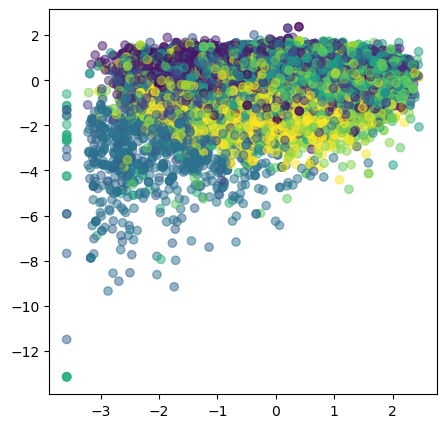

In [21]:
plt.figure(figsize=(5, 5))
plt.scatter(X_prep[:, 0], X_prep[:, 3], c=clusters,alpha=0.5)
plt.show()

In [22]:
# Authentification Spotify API

In [23]:
secrets_file = open("secrets.txt","r")

In [24]:
string = secrets_file.read()

In [25]:
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        #print(line.split(':'))
        secrets_dict[line.split(':')[0]]=line.split(':')[1].strip()

In [26]:
#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['clientid'],
                                                           client_secret=secrets_dict['clientsecret']))

In [ ]:
# First version:

In [ ]:
def remove_special_characters(text):
    # Remove special characters using a regular expression
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def recommend_song(input_song, input_artist):

    # Convert the user input and song names to lowercase for case-insensitive comparison
    input_song_lower = input_song.lower()
    input_artist_lower = input_artist.lower()

    top_songs_lower = top_songs.apply(lambda x: x.str.lower().apply(remove_special_characters))
    top_songs_lower['song'] = top_songs_lower['song'].apply(remove_special_characters)

    # Check if the user-inputted song is in the top songs list (case-insensitive)
    if input_song_lower in top_songs_lower['song'].values:
        # Filter out the user-inputted song from the DataFrame
        top_songs_without_input = top_songs[
            top_songs_lower['song'] != input_song_lower
        ]

        # Recommend a random song from the filtered df
        recommended_song = top_songs_without_input.sample().squeeze()

        print(f"You might also like: {recommended_song['song']} by {recommended_song['artist']}")
        
    else:
        
        #Opening the spotify connection
        sp = open_spotify_connection()

        # Search for the user-inputted song and artist on Spotify
        search_results = sp.search(q=f"{input_song} {input_artist}", type='track', limit =1 )

        if not search_results['tracks']['items']:
            print("Song not found on Spotify. Please try another song.")
            return

        # Get the track ID for the user-inputted song
        if search_results['tracks']['total']!=0 :
            track_id = search_results['tracks']['items'][0]['id']
            #print(track_id)
        
        # Getting the audio features using the id
        new_data = sp.audio_features(track_id)
        #print(type(new_data[0]))
        data_df = json_normalize(new_data[0]) #normalizing the data to a df
        num_data_df = data_df.select_dtypes(include='number') #getting the numerical data only to fit
        #print(num_data_df)

        #Using pickle to get the existing scaler and kmean
        kmeans = pickle.load(open('kmean.pkl', 'rb'))
        scaler = pickle.load(open('scaler.pkl','rb'))
        X_prep = scaler.transform(num_data_df)
        predicted_cluster = kmeans.predict(X_prep)
        
        # Predict the cluster for the input song using the clustering model
        cluster = predicted_cluster[0]
        #print(cluster)
        
        # Filter songs in the same cluster from the playlist DataFrame and
        # Recommend a random song from the same cluster
        recommended_song = playlist_df[playlist_df['cluster']== cluster].sample().squeeze()
        # print(recommended_song)

        print(f"You might also like: {recommended_song['track.name']} by {recommended_song['name']}")

        # Introduce a respectful nap to avoid hitting rate limits
        sleep(randint(1, 3000) / 1000)


In [ ]:
def open_spotify_connection():
    #Opens a new spotify connection
    secrets_file = open("secrets.txt","r")
    string = secrets_file.read()
    secrets_dict={}
    for line in string.split('\n'):
        if len(line) > 0:
            #print(line.split(':'))
            secrets_dict[line.split(':')[0]]=line.split(':')[1].strip()
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['clientid'],
                                                           client_secret=secrets_dict['clientsecret']))
    return sp;

In [ ]:
# Get user input for song and artist
input_song = input("Enter a song: ")
input_artist = input("Enter the artist: ")
recommend_song(input_song, input_artist )